Simulation of the cell cycle and apoptosis model biochemically and in a cell population
=========

## Simulation with the original parameters

The parameters refer to the biochemical constants. The first step is importing the model and dependencies. The model and the simulations are done within the package PySB [ref].

*to be done


In [1]:
import os
import sys

sys.path.append("cellular_cycle")
sys.path.append("fit")

import numpy as np
import pandas as pd
from matplotlib import pyplot as pl
# import pylab as pl
import seaborn as sns

##Importing the model, models differ on their initial conditions, one being a concentration and the other a protein count
from Austin_proliferation_model_concentration_5 import model
model_concentration=model
from Austin_proliferation_model_population_5 import model
model_population=model

##Import the simulator: for ODE and stochastic simulation :
from pysb.simulator import BngSimulator
from pysb.simulator import ScipyOdeSimulator


## Simulation of biochemical modem

Now we execute the model with the original parameters and the initial conditions. Let's start with simulating the biochemical model with a set of ordinary differential equations and then with the Gillespie's Stochastic Simulation Algorithm both available in the PySB package.

#### Deteriministic simulation


2021-08-10 11:55:46.497 - pysb.simulator.scipyode - WARNING - [Austin_proliferation_ODE_model_5] This system of ODEs will be evaluated in pure Python. This may be slow for large models. We recommend installing the 'cython' package for compiling the ODEs to C code. This warning can be suppressed by specifying compiler='python'.


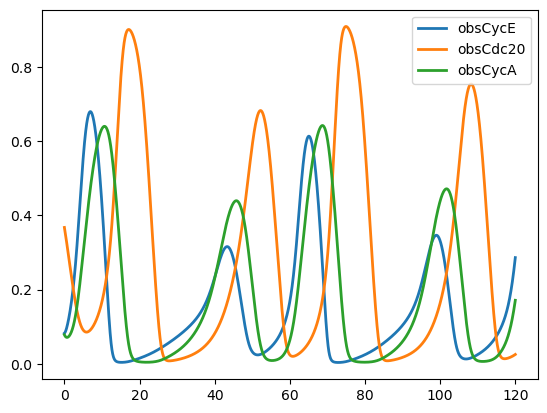

In [2]:
#ODE simulation

t = np.linspace(0, 120, 120000)
simres = ScipyOdeSimulator(model_concentration, t, verbose=False).run(); #deterministic simulation
yout = simres.all;
observables=['obsCycE','obsCdc20', 'obsCycA']; #plot Cyclin E, Cdc20 and Cyclin A

for obs in range(3) :
    pl.plot(t,yout[observables[obs]], label=observables[obs], lw=2)
pl.legend(loc=0)
pl.show()


#### Stochastic simulation


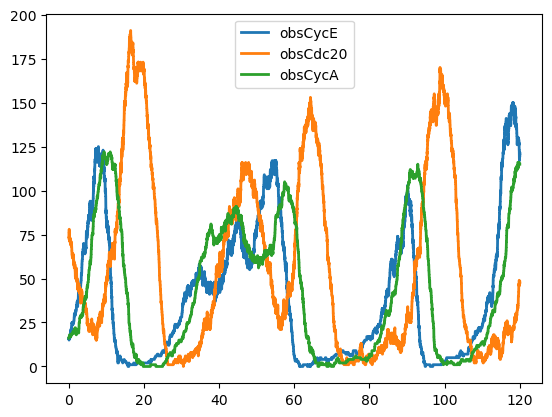

In [3]:
#Stochastic simulation
t = np.linspace(0, 120, 170000);
sim = BngSimulator(model_population, tspan=t, verbose=False); #stochastic simulator
simres = sim.run(method='ssa', verbose=False); #running the simulation
yout = simres.observables;
observables=['obsCycE','obsCdc20', 'obsCycA']; #plot Cyclin E, Cdc20 and Cyclin A


for obs in range(3) :    
    pl.plot(t,yout[observables[obs]], label=observables[obs], lw=2)
pl.legend(loc=0)
pl.show()


## Simulation of a population of cells

In order to reproduce faithfully the experiments we run a population of cells. Each events is registered, if death occurs the simulation stops, if a mitosis occurs, a new simulation occurs from the division time.

#### Simulating the population


In [4]:
#from runAKTERK_2_starting_at_mitosis import runAKTERK #Cell population simulation
from runAKTERK_2 import runAKTERK #Cell population simulation
from retrieve_cellState_dw import retrieve_cellState
from plot_frac_div_q_ap1 import all_events
from runStochCell import runStochcell

run_time=120 #how long is the experiment
observed_cells_time=120 #how long are we looking at new cells
nber_of_starting_cells=12 #size of initial population
index="_" #to be removed...
condition="_" #to be removed...


#(cells, cell_count) = runAKTERK(nber_of_starting_cells, run_time, observed_cells_time, model_concentration, model_population, index, condition);
(cells, cell_count) = runAKTERK(nber_of_starting_cells, run_time, observed_cells_time, model_concentration, model_population, index, condition);
#index and conditions to save the identity of the simulation (to remove?)

IMT_eoe_counts = retrieve_cellState(run_time, nber_of_starting_cells, cells); #Gives the cells life per cycle
all_events_simulated = all_events(run_time, IMT_eoe_counts); #Gives all events (apoptosis, mitosis, quiescence and when they happen)

2021-08-10 11:56:07.968 - pysb.simulator.scipyode - WARNING - [Austin_proliferation_ODE_model_5] This system of ODEs will be evaluated in pure Python. This may be slow for large models. We recommend installing the 'cython' package for compiling the ODEs to C code. This warning can be suppressed by specifying compiler='python'.


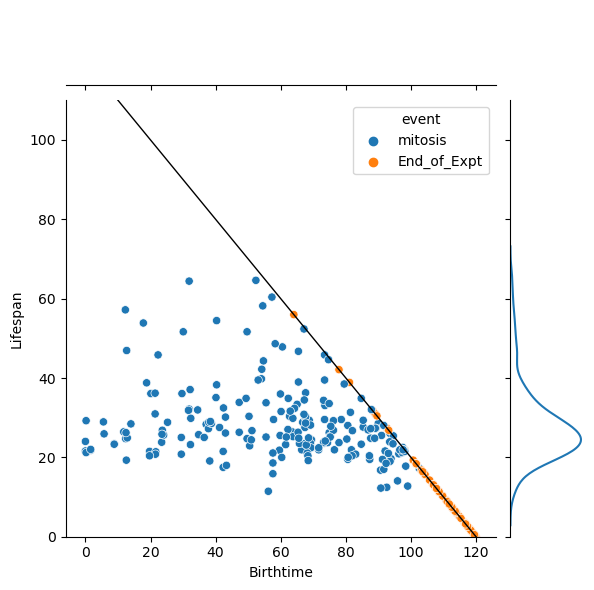

In [5]:
#plot the results
grid = sns.JointGrid(x='Birthtime', y='Lifespan', data=all_events_simulated) #x axis = birthtime of a cell, y = endtime of this cell
g = grid.plot_joint(sns.scatterplot, hue='event', data=all_events_simulated) 
g.ax_joint.plot([run_time, 0], [0, run_time], 'b-', linewidth = 1, color='black') #Recorded events behind this line
sns.kdeplot(all_events_simulated.loc[all_events_simulated['event']=='mitosis', 'Lifespan'], ax=g.ax_marg_y, vertical=True, legend=False, bw=0.3) #output distribution of intermitotic times
pl.ylim(0, 110)
pl.show()

#### Calculating the parameters assuming the fractional proliferation model
We can calculated the parameters associated with the fractional proliferation model

*Recall the formula for fractional proliferation model + ref


In [6]:
import fracprolif as fp

mitotic_lifespans = all_events_simulated['Lifespan'][all_events_simulated['event']=='mitosis']
censored_lifespans = all_events_simulated['Lifespan'][all_events_simulated['event']=='End_of_Expt']

number_of_deaths = len(all_events_simulated) - (all_events_simulated['event']=='apoptosis').value_counts()[0]
cell_time_total = sum(all_events_simulated['Lifespan'])
print("death rate = " + str(number_of_deaths/cell_time_total)) #death rate (death event/time)


m = fp.mle(mitotic_lifespans, censored_lifespans);
print("μ = " + str(m['x'][0])) #mu
print("σ = " + str(m['x'][1])) #sigma
print("λ = " + str(m['x'][2])) #lambda


death rate = 0.0
μ = 19.811733209800938
σ = 3.690308780911659
λ = 0.11089973742578883


#### Calculating a cost for this set of parameters

Once the simulation is done we can calculate a cost associated with the parameters 


## Simulation with the fitted parameters

#### Let's first import the parameters

In [7]:
frac_prolif_parameters = pd.read_pickle("./fit_data/sobol_seq/frac_prolif_parameters_all_parameters_006_55_kPa.pkl")

#Original parameters
pysb_sampled_parameter_names = ["V_s2skp","V_Fp","k_M","k_EMY","k_CDF","k_CDS","k_ED","K_S","K_MY","K_DF","d_CD","k_P1", "k_P2", "K_CD", "k_E", "K_M", "K_CE", "V_2E2F", "K_2E2F", "k_RE", "kf1", "kf2", "kb", "kasbaxmbcl2", "kdsbaxmbcl2", "k1sbh3", "k2sbh3", "kdbh3", "kasbh3bcl2", "kdsbh3bcl2"]
loc=[]
for parameter in pysb_sampled_parameter_names:
    loc+=[np.log10(model.parameters[parameter].value)] 


#Generating the sobol sequence
import sobol_seq
l = sobol_seq.i4_sobol_generate(30, 140000, skip = 0)
l2 = 4*l + (np.array(loc)-2)

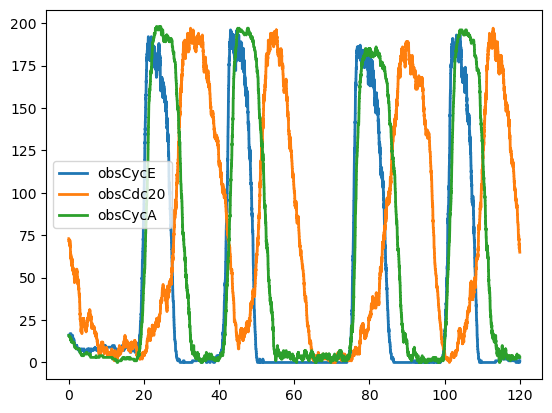

In [8]:
#indices in the sobol sequence for the 100 best parameters
indices = [int(i)-1 for i in frac_prolif_parameters.sort_values(by=['cost_total'])["index"].tolist()[0:100]] 
parameters = [l2[i] for i in indices]

#Change model parameter values to current location in parameter space
parameter_vector = 10**parameters[0]
param_dict = {pname: pvalue for pname, pvalue in zip(pysb_sampled_parameter_names, parameter_vector)}   
for pname, pvalue in param_dict.items():
    model_population.parameters[pname].value = (pvalue)
    model_concentration.parameters[pname].value = (pvalue)

sim = BngSimulator(model_population, tspan=t, verbose=False);
simres2 = sim.run(method='ssa', verbose=False);
yout = simres2.observables;
observables=['obsCycE','obsCdc20', 'obsCycA'];


for obs in range(3) :    
    pl.plot(t,yout[observables[obs]], label=observables[obs], lw=2)
pl.legend(loc=0)
pl.show()